### Import libraries

In [3]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import platform

from datetime import datetime

import random
random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [5]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from PIL import Image
import imagehash
from sklearn.model_selection import KFold
import zipfile

In [6]:
# Setup Mixed Precision

# Detect TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else: 
  policyConfig = 'mixed_float16'

#policy = tf.keras.mixed_precision.Policy(policyConfig)
#tf.keras.mixed_precision.set_global_policy(policy)

### Load the dataset

In [7]:
# Load the data from the file
file_path = 'cleaned_data.npz'
loaded_data = np.load(file_path, allow_pickle=True)

# Put data into proper arrays
data = loaded_data['data']
labels = loaded_data['labels']

### Prepare and augment data

In [8]:
healthy = []
unhealthy = []

# Iterate through the images to separate them into the proper set
for i, image in enumerate(data):
    if labels[i] == 'unhealthy':
        unhealthy.append(image)
    else:
        healthy.append(image)

print(len(healthy))
print(len(unhealthy))

3060
1790


In [19]:
flip = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
])

rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.2),
])

zoom = tf.keras.Sequential([
  tfkl.RandomZoom(0.2),
])

translation = tf.keras.Sequential([
  tfkl.RandomTranslation(0.2,0.2),
])

contrast = tf.keras.Sequential([
  tfkl.RandomContrast(0.75),
])

brightness = tf.keras.Sequential([
  tfkl.RandomBrightness(0.5, value_range=(0,1)),
])

####

In [20]:
healthy = np.array(healthy)
N = 900
N2 = int(N/2)

# Preprocess 'healthy' set
preprocessed_healthy_flip = healthy[:N]
preprocessed_healthy_flip = flip(preprocessed_healthy_flip)

preprocessed_healthy_rotate = healthy[:N]
preprocessed_healthy_rotate = rotation(preprocessed_healthy_rotate)

preprocessed_healthy_zoom = healthy[: N2]
preprocessed_healthy_zoom = zoom(preprocessed_healthy_zoom)

preprocessed_healthy_translation = healthy[: N2]
preprocessed_healthy_translation = translation(preprocessed_healthy_translation)

preprocessed_healthy_constrast = healthy[: N2]
preprocessed_healthy_constrast = contrast(preprocessed_healthy_constrast)

preprocessed_healthy_brightness = healthy[: N2]
preprocessed_healthy_brightness = contrast(preprocessed_healthy_brightness)

preprocessed_healthy = np.concatenate([
    preprocessed_healthy_rotate, 
    preprocessed_healthy_flip,
    preprocessed_healthy_zoom,
    preprocessed_healthy_translation,
    preprocessed_healthy_constrast,
    preprocessed_healthy_brightness
], axis=0)


In [21]:
unhealthy = np.array(unhealthy)
M = 1500
M2 = int(M/3)

# Preprocess 'healthy' set
preprocessed_unhealthy_flip = unhealthy[:M]
preprocessed_unhealthy_flip = flip(preprocessed_unhealthy_flip)

preprocessed_unhealthy_rotate = unhealthy[:M]
preprocessed_unhealthy_rotate = rotation(preprocessed_unhealthy_rotate)

preprocessed_unhealthy_zoom = unhealthy[: M2]
preprocessed_unhealthy_zoom = zoom(preprocessed_unhealthy_zoom)

preprocessed_unhealthy_translation = unhealthy[: M2]
preprocessed_unhealthy_translation = translation(preprocessed_unhealthy_translation)

preprocessed_unhealthy_constrast = unhealthy[: M2]
preprocessed_unhealthy_constrast = contrast(preprocessed_unhealthy_constrast)

preprocessed_unhealthy_brightness = healthy[: N2]
preprocessed_unhealthy_brightness = contrast(preprocessed_unhealthy_brightness)

preprocessed_unhealthy = np.concatenate([
    preprocessed_unhealthy_rotate, 
    preprocessed_unhealthy_flip,
    preprocessed_unhealthy_zoom,
    preprocessed_unhealthy_translation,
    preprocessed_unhealthy_constrast,
    preprocessed_unhealthy_brightness
], axis=0)

In [22]:
# Concatenate the preprocessed sets
preprocessed_data = np.concatenate([preprocessed_healthy, preprocessed_unhealthy], axis=0)

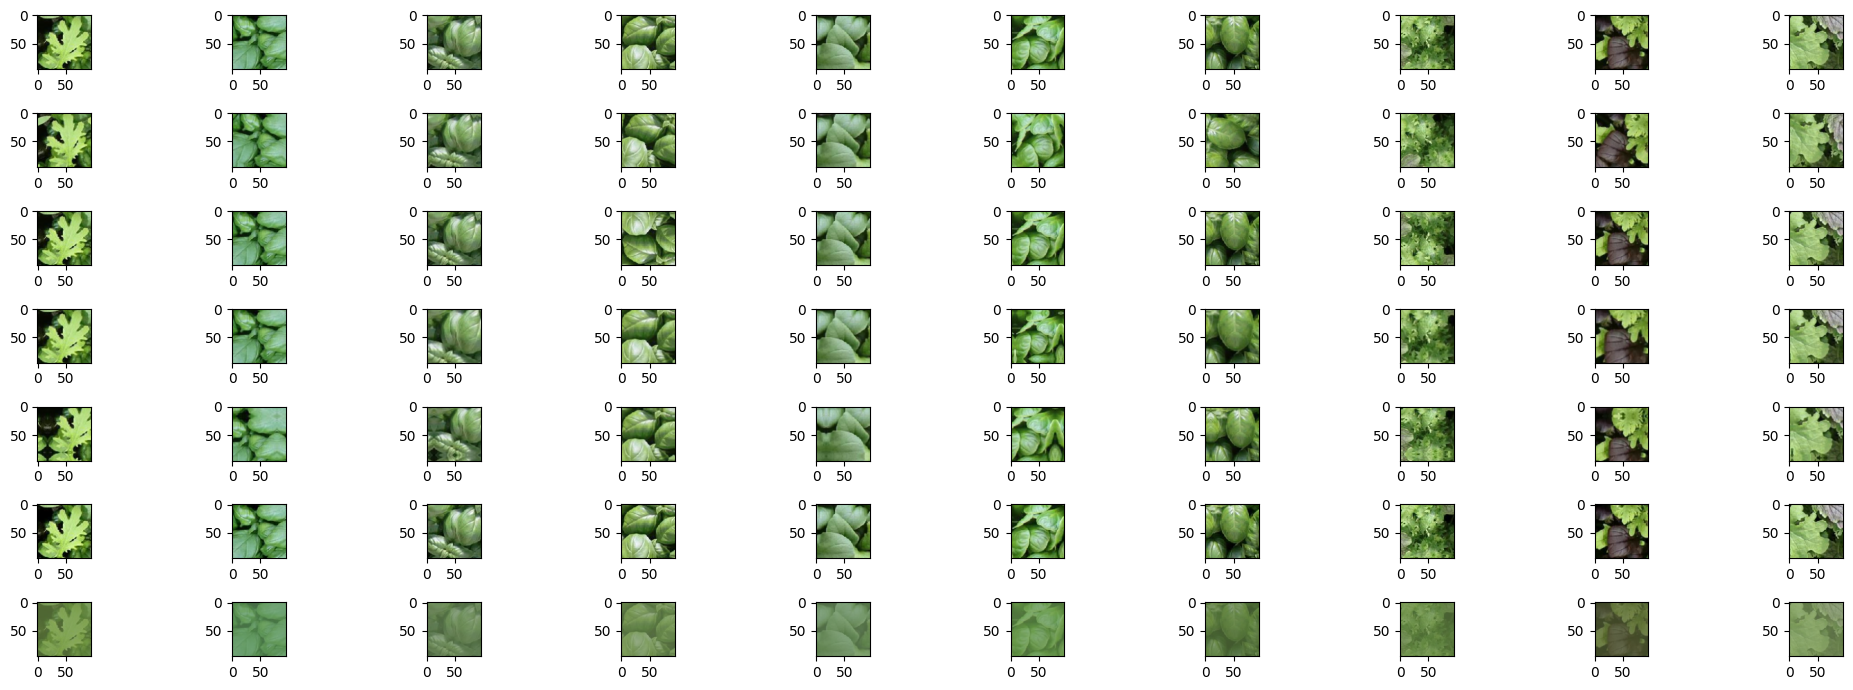

In [23]:
# Plot
healthy_np = np.array(healthy)
preprocessed_healthy_rotate_np = np.array(preprocessed_healthy_rotate)
preprocessed_healthy_flip_np = np.array(preprocessed_healthy_flip)
preprocessed_healthy_zoom_np = np.array(preprocessed_healthy_zoom)
preprocessed_healthy_translation_np = np.array(preprocessed_healthy_translation)
preprocessed_healthy_contrast_np = np.array(preprocessed_healthy_constrast)
preprocessed_healthy_brightness_np = np.array(preprocessed_healthy_brightness)

num_img = 10

fig, axes = plt.subplots(7, num_img, figsize=(20, 7))
for i in range(num_img):
    ax = axes[0, i % num_img]
    ax.imshow(healthy_np[i].astype(np.uint8), cmap='gray')
    ax = axes[1, i % num_img]
    ax.imshow(preprocessed_healthy_rotate_np[i].astype(np.uint8), cmap='gray')
    ax = axes[2, i % num_img]
    ax.imshow(preprocessed_healthy_flip_np[i].astype(np.uint8), cmap='gray')
    ax = axes[3, i % num_img]
    ax.imshow(preprocessed_healthy_zoom_np[i].astype(np.uint8), cmap='gray')
    ax = axes[4, i % num_img]
    ax.imshow(preprocessed_healthy_translation_np[i].astype(np.uint8), cmap='gray')
    ax = axes[5, i % num_img]
    ax.imshow(preprocessed_healthy_contrast_np[i].astype(np.uint8), cmap='gray')
    ax = axes[6, i % num_img]
    ax.imshow(preprocessed_healthy_brightness_np[i].astype(np.uint8), cmap='gray')
    

plt.tight_layout()
plt.show()

In [24]:
print(len(preprocessed_healthy)) 
print(len(preprocessed_unhealthy))
print(len(preprocessed_data))

3600
4950
8550


In [25]:
augmented_data = np.concatenate([preprocessed_data, data], axis = 0)

augmented_labels_healthy = np.full((len(preprocessed_healthy),), 'healthy', dtype='object')
augmented_labels_unhealthy = np.full((len(preprocessed_unhealthy),), 'unhealthy', dtype='object')

augmented_labels = np.concatenate([augmented_labels_healthy, augmented_labels_unhealthy, labels], axis=0)

np.savez('augmented_data.npz', data=augmented_data, labels=augmented_labels)

print(len(augmented_data))
print(len(augmented_labels))

13400
13400


### Load and process the (augmented) dataset

In [26]:
file_path = 'augmented_data.npz'
loaded_data = np.load(file_path, allow_pickle = True)

# Access the 'data' and 'labels' arrays
data = loaded_data['data']
labels = loaded_data['labels']

print(len(data))
print(len(labels))

healthy = []
unhealthy = []

# Iterate through the images to separate them into the proper set
for i, image in enumerate(data):
    if labels[i] == 'unhealthy':
        unhealthy.append(image)
    else:
        healthy.append(image)

print(len(healthy))
print(len(unhealthy))

13400
13400
6660
6740


In [27]:
# Concatenate 'healthy' and 'unhealthy' arrays along axis 0
X = np.concatenate([healthy, unhealthy], axis = 0)

# Create labels: 1 for 'healthy', 0 for 'unhealthy'
y = np.concatenate([np.ones(len(healthy)), np.zeros(len(unhealthy))], axis = 0)

# y = tfk.utils.to_categorical(y,len(np.unique(y)))
y = np.expand_dims(y, axis=-1)  # Add a singleton dimension for compatibility with binary classification

# Split data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=np.argmax(y,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (10720, 96, 96, 3), y_train shape: (10720, 1)
X_val shape: (2680, 96, 96, 3), y_val shape: (2680, 1)


In [28]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 100

img_height = 96
img_width = 96

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (1,), Batch Size: 32, Epochs: 100


In [29]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='auto'),
]

### Train the (sequential) model

In [30]:
# Macs with Apple Silicon suffer performance penalties when using the modern Adam optimizer
# Detect system specs and select the appropriate optimizer

if platform.system() == "Darwin" and platform.processor() == "arm":
    optimizer = tf.keras.optimizers.legacy.Adam()
else:
    optimizer = tf.keras.optimizers.Adam()

In [31]:
def build_model(input_shape=input_shape, dropout_rate=0.4):
    tf.random.set_seed(seed)

    input_layer = tf.keras.Input(shape=input_shape, name='Input')

    conv1 = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed)
    )(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D()(conv1)
    pool1 = tf.keras.layers.Dropout(dropout_rate, seed=seed)(pool1)

    conv2 = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed)
    )(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D()(conv2)
    pool2 = tf.keras.layers.Dropout(dropout_rate, seed=seed)(pool2)

    conv3 = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=3,
        padding='same',
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed)
    )(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = tf.keras.layers.MaxPooling2D()(conv3)
    pool3 = tf.keras.layers.Dropout(dropout_rate, seed=seed)(pool3)
    
    final_pool = pool3

    gap_layer = tf.keras.layers.GlobalAveragePooling2D(name='Gap')(final_pool)
    
    dropout = tf.keras.layers.Dropout(dropout_rate, seed=seed)(gap_layer)

    l1_strength = 0.0005
    l2_strength = 0.01
    
    # Use 1 unit for binary classification (2 classes)
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation='sigmoid',  # Use 'sigmoid' for binary classification
        kernel_initializer=tf.keras.initializers.HeUniform(seed),
        name='output_layer',
        kernel_regularizer = tf.keras.regularizers.L1L2(l1=l1_strength, l2=l2_strength)
    )(dropout)

    # Define the learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005,
        decay_steps=10000,
        decay_rate=0.9
    )

    # Connect input and output through the Model class
    model = tf.keras.Model(
        inputs=input_layer,
        outputs=output_layer,
        name='model')

    # Compile the model with the customized optimizer
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=['accuracy'])

    # Return the model
    return model


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 96, 96, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496 

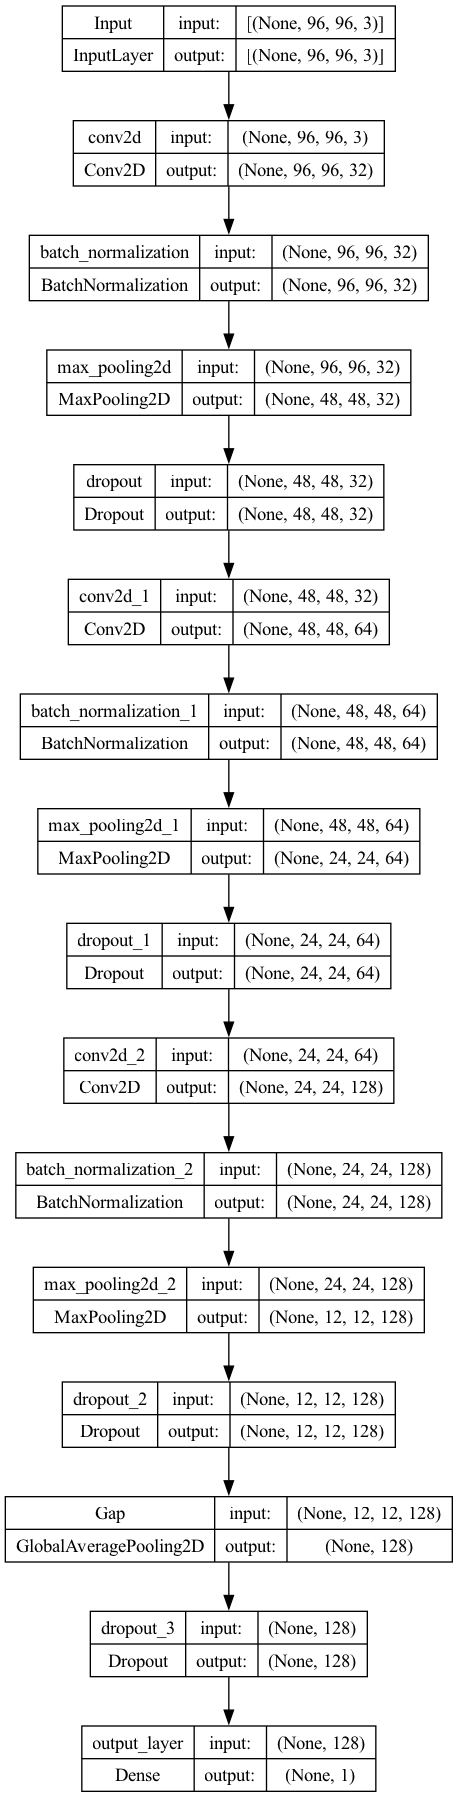

In [32]:
# Build the model and return a summary about it
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

### Train the model

In [33]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history


Epoch 1/100
335/335 [==============================] - 14s 32ms/step - loss: 0.6754 - accuracy: 0.6253 - val_loss: 0.6634 - val_accuracy: 0.6675
Epoch 2/100
335/335 [==============================] - 10s 29ms/step - loss: 0.6007 - accuracy: 0.6948 - val_loss: 1.0451 - val_accuracy: 0.5713
Epoch 3/100
335/335 [==============================] - 10s 29ms/step - loss: 0.5662 - accuracy: 0.7210 - val_loss: 0.6038 - val_accuracy: 0.7063
Epoch 4/100
335/335 [==============================] - 10s 29ms/step - loss: 0.5479 - accuracy: 0.7326 - val_loss: 0.5857 - val_accuracy: 0.7007
Epoch 5/100
335/335 [==============================] - 10s 29ms/step - loss: 0.5305 - accuracy: 0.7415 - val_loss: 0.5416 - val_accuracy: 0.7556
Epoch 6/100
335/335 [==============================] - 10s 29ms/step - loss: 0.5147 - accuracy: 0.7484 - val_loss: 0.5084 - val_accuracy: 0.7530
Epoch 7/100
335/335 [==============================] - 10s 29ms/step - loss: 0.5024 - accuracy: 0.7600 - val_loss: 0.5558 - val_ac

### Validate the (sequential) model

In [34]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"model_{formatted_datetime}.zip"
model.save(zipfile_name)

X_test_1 = X_val
X_test_2 = rotation(X_val)
X_test_3 = flip(X_val)

true_labels = y_val

# Make predictions on each test set
predictions_1 = model.predict(X_test_1)
predictions_2 = model.predict(X_test_2)
predictions_3 = model.predict(X_test_3)

# Assuming binary classification, adjust if needed

best_accuracy_1 = 0.0
limit_1 = 0.0

for limit in range(100):
    predicted_labels_1 = (predictions_1 > (limit / 100.0)).astype(int)
    accuracy_1 = np.sum(predicted_labels_1 == true_labels) / len(true_labels)
    
    if (accuracy_1 < best_accuracy_1):
        continue
        
    best_accuracy_1 = accuracy_1
    limit_1 = (limit / 100.0)
        
best_accuracy_2 = 0.0
limit_2 = 0.0

for limit in range(100):
    predicted_labels_2 = (predictions_2 > (limit / 100.0)).astype(int)
    accuracy_2 = np.sum(predicted_labels_2 == true_labels) / len(true_labels)
    
    if (accuracy_2 < best_accuracy_2):
        continue
        
    best_accuracy_2 = accuracy_2
    limit_2 = (limit / 100.0)

best_accuracy_3 = 0.0
limit_3 = 0.0

for limit in range(100):
    predicted_labels_3 = (predictions_3 > (limit / 100.0)).astype(int)
    accuracy_3 = np.sum(predicted_labels_3 == true_labels) / len(true_labels)
    
    if (accuracy_3 < best_accuracy_3):
        continue
        
    best_accuracy_3 = accuracy_3
    limit_3 = (limit / 100.0)


print("Limit on Test Set 1:", limit_1)
print("Limit on Test Set 2:", limit_2)
print("Limit on Test Set 3:", limit_3)
        
predicted_labels_1 = (predictions_1 > limit_1).astype(int)
predicted_labels_2 = (predictions_2 > limit_2).astype(int)
predicted_labels_3 = (predictions_3 > limit_3).astype(int)

# Compare the results
accuracy_1 = np.sum(predicted_labels_1 == true_labels) / len(true_labels)
accuracy_2 = np.sum(predicted_labels_2 == true_labels) / len(true_labels)
accuracy_3 = np.sum(predicted_labels_3 == true_labels) / len(true_labels)

print("Accuracy on Test Set 1:", accuracy_1)
print("Accuracy on Test Set 2:", accuracy_2)
print("Accuracy on Test Set 3:", accuracy_3)


final_prediction = []

for i in range(len(predictions_1)):
    healthy_prediction = predicted_labels_1[i] + predicted_labels_2[i] + predicted_labels_3[i]
    
    if (healthy_prediction >= 2):
        final_prediction.append([1])
        
    else:
        final_prediction.append([0])
        
final_accuracy = np.sum(final_prediction == true_labels) / len(true_labels)

print("Accuracy of Final Prediction:", final_accuracy)

84/84 [==============================] - 1s 8ms/step
Limit on Test Set 1: 0.81
Limit on Test Set 2: 0.75
Limit on Test Set 3: 0.79
Accuracy on Test Set 1: 0.8828358208955224
Accuracy on Test Set 2: 0.85
Accuracy on Test Set 3: 0.8600746268656716
Accuracy of Final Prediction: 0.8776119402985074


Predictions on Test Set 1:
[[8.9044434e-01]
 [5.8825943e-04]
 [9.9742931e-01]
 [8.0445380e-04]
 [9.1311455e-01]
 [9.2732739e-01]
 [9.7305804e-01]
 [8.8543276e-04]
 [9.3350297e-01]
 [7.7524108e-01]]

Predictions on Test Set 2:
[[9.5275646e-01]
 [2.0438957e-03]
 [9.9920291e-01]
 [6.4391582e-03]
 [8.3375514e-01]
 [9.6039635e-01]
 [9.6189642e-01]
 [2.3890933e-04]
 [9.8066151e-01]
 [5.2332968e-01]]

Predictions on Test Set 3:
[[8.9044434e-01]
 [5.8825943e-04]
 [7.7937555e-01]
 [4.3077697e-03]
 [9.1311455e-01]
 [5.7865328e-01]
 [9.1134310e-01]
 [8.8543276e-04]
 [9.3350297e-01]
 [1.2168567e-01]]

Final Predictions:
[[1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]]


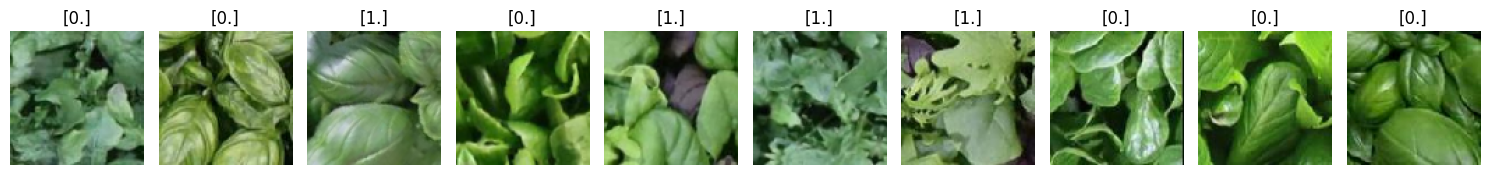

In [35]:
# N predictions to display
N = 10

# Output the first N predictions for each set
print("Predictions on Test Set 1:")
print(predictions_1[:N])

print("\nPredictions on Test Set 2:")
print(predictions_2[:N])

print("\nPredictions on Test Set 3:")
print(predictions_3[:N])

print("\nFinal Predictions:")
print(np.array(final_prediction[:N]))

# Create subplots
fig, axes = plt.subplots(1, N, figsize=(15, 5))

for i in range(N):
    # Plot the original image from X_val
    ax = axes[i]
    ax.imshow(X_val[i].astype(np.uint8))
    ax.set_title(y_val[i])
    ax.axis('off')

plt.tight_layout()
plt.show()


### Plot the training

In [ ]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# K fold

### train the model

In [ ]:
# Train the model
# Define the number of folds
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Initialize lists to store the results from each fold
all_train_loss = []
all_train_acc = []
all_val_loss = []
all_val_acc = []

initial_learning_rate = 0.0001
lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 10000,
    decay_rate = 0.9,
    staircase = True,
)

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Build the model
    model = build_model(input_shape=X_train.shape[1:], dropout_rate=0.4)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs = epochs,
        batch_size = batch_size,
        validation_data = (X_val, y_val),
        verbose = 1
    )

    # Evaluate on training set
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    all_val_loss.append(val_loss)
    all_val_acc.append(val_acc)

# Print average results over all folds
print(f"Average Training Loss: {np.mean(all_train_loss)}")
print(f"Average Training Accuracy: {np.mean(all_train_acc)}")
print(f"Average Validation Loss: {np.mean(all_val_loss)}")
print(f"Average Validation Accuracy: {np.mean(all_val_acc)}")

# Plot the training

In [ ]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()


# Save the model and create submission

In [36]:
import os
import zipfile
from datetime import datetime
import tensorflow as tf
from os.path import basename

# Specify the name of the submission folder
submission_folder = "SubmissionModel"

# Save best epoch model
model.save(os.path.join(submission_folder, "SubmissionModel"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf
from tensorflow.keras import layers as tfkl

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):
        # Define the RandomRotation layer
        rotation = tf.keras.Sequential([
            tfkl.RandomRotation(0.3),
        ])

        # Define the RandomFlip layer
        flip = tf.keras.Sequential([
            tfkl.RandomFlip("vertical"),
        ])

        limit = tf.constant(0.56, dtype=tf.float32)

        X_test_1 = X
        X_test_2 = rotation(X) 
        X_test_3 = flip(X)

        out1 = self.model.predict(X_test_1)
        out2 = self.model.predict(X_test_2)
        out3 = self.model.predict(X_test_3)

        out1 = tf.argmax(out1, axis=-1)  # Shape [BS]
        out2 = tf.argmax(out2, axis=-1)  # Shape [BS]
        out3 = tf.argmax(out3, axis=-1)  # Shape [BS]
        
        out = []  # Initialize out as an empty list
        
        for i in range(len(out1)):
            hp = 0
        
            if tf.cast(out1[i], tf.float32) > limit:
                hp += 1
        
            if tf.cast(out2[i], tf.float32) > limit:
                hp += 1
        
            if tf.cast(out3[i], tf.float32) > limit:
                hp += 1
        
            if hp >= 2:
                out.append([1])
            else:
                out.append([0])

        out = tf.argmax(out, axis=-1)  # Shape [BS]

        return out
""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)
            
            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue
        
            # print(foldername)
            print(file_path)
            
            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)


SubmissionModel/SubmissionModel/fingerprint.pb
SubmissionModel/SubmissionModel/keras_metadata.pb
SubmissionModel/SubmissionModel/saved_model.pb
SubmissionModel/SubmissionModel/variables/variables.data-00000-of-00001
SubmissionModel/SubmissionModel/variables/variables.index
SubmissionModel_20231114_205541.zip
